<h1>Covid Data Prep</h1>
<h3>Feature Engineering</h3>
<p>The notebook below takes the Covid-19 df and prepares it to use in Deep Learning Notebooks</p>
<br>
<p>The raw data consists of the following feature</p>
<ol>
    <li>dateRep</li>
    <li style="color:red;">day</li>
    <li style="color:red;">month</li>
    <li style="color:red;">year</li>
    <li>cases</li>
    <li>deaths</li>
    <li>countriesAndTerritories</li>
    <li style="color:red;">geoId</li>
    <li style="color:red;">countryterritorycode</li>
    <li>popData2018</li>
    <li>continentExp</li>
</ol>
<br>
</p>Feature names in red will be remove as they were defined as adding little information to the model. The remaining feautures will be evaluated through the notebook below.</p>

<h5>Import dependancies</h5>
<ul>
    <li>pandas: feature extrapolation and extraction and creation</li>
    <li>numpy: numerical data manipluation</li>
    <li>os: interaction with the operating system</li>
    <li>seaborn: plotting library</li>
    <li>sklearn.model_selection.train_test_split: spliting the data into the various data sets (train, test and validation)</li>
</ul>

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import datetime as dt

</h2>Read in raw data</h2>

<p>Change to the relevant directory and read in the csv</p>

The csv will need some preprocessing

In [152]:
data_folder = os.path.join(os.getcwd(), 'Datasets')

<p>Now read the file. No Line should need skipping.</p>

In [363]:
# Import and format dataframe
covid19_df = pd.read_csv(os.path.join(data_folder, 'COVID-19_Cases_Worldwide_2020_08_21'), engine='python')
covid19_df.head(2)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,20/08/2020,20,8,2020,160,8,Afghanistan,AF,AFG,38041757.0,Asia,2.268560
1,19/08/2020,19,8,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,2.024092


In [364]:
# Columns to drop
drop_columns = ['geoId', 'day', 'month', 'year', 'countryterritoryCode']
# Create a 'datetime' column based on the dates
covid19_df['dateRep'] = pd.to_datetime(covid19_df['dateRep'], dayfirst=True)
# Drop the columns that add no value
covid19_df.drop(columns=drop_columns, inplace=True)

In [365]:
# Sort the table by the date
covid19_df.sort_values(by=['dateRep'], ascending=True, inplace=True)
# Create a cumulative sum of covid cases and deaths
covid19_df['Cum_Cases'] = covid19_df.groupby("countriesAndTerritories")['cases'].cumsum()
covid19_df['Cum_Deaths'] = covid19_df.groupby("countriesAndTerritories")['deaths'].cumsum()

In [366]:
# Create column for days since x deaths
covid19_df['flag'] = np.where(covid19_df['Cum_Cases'] > 100, 1, 0) # calculate globaly as its a true false
# groupby again creating a unique dataframe for each country, and applying a cumulative sum to the "flag" column
covid19_df['flag'] = covid19_df.loc[covid19_df['Cum_Cases'] > 100].groupby("countriesAndTerritories")['flag'].cumsum()

<p>We don't want Nan's so we replace them in the next few cells below</p>

In [367]:
top_count = covid19_df.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:20]
top_count = list(top_count.keys())
print(top_count)

['United_States_of_America', 'Brazil', 'Mexico', 'India', 'United_Kingdom', 'Italy', 'France', 'Spain', 'Peru', 'Iran', 'Russia', 'Colombia', 'South_Africa', 'Chile', 'Belgium', 'Germany', 'Canada', 'Indonesia', 'Pakistan', 'Netherlands']


In [368]:
# Trim the dataframe to just the 20 most affected countries
covid19_df = covid19_df[covid19_df['countriesAndTerritories'].isin(top_count)]

In [369]:
# Load in Apple mobility data
mobility_df = pd.read_csv(os.path.join(data_folder, 'Apple_Mobility' , 'applemobilitytrends-2020-08-19.csv'), engine='python')
# Only select the overall country data 'country/region' and drop columns not needed
mobility_df = mobility_df.loc[mobility_df['geo_type'] == 'country/region'].drop(columns=['sub-region', 'country', 'alternative_name', 'geo_type'])

In [370]:
# 'melt' the dataframe so that dates are listed by row and not column
mobility_df = mobility_df.melt(id_vars=['transportation_type', 'region'])
# Format the strings so the countries match e.g. remove space and add in underscore.
mobility_df = mobility_df.replace({'region': {'United States': 'United_States_of_America', 'Republic of Korea': 'South_Korea', ' ': '_'}}, regex=True)
# Create a 'datetime' column
mobility_df['variable'] = pd.to_datetime(mobility_df['variable'], dayfirst=True)

In [371]:
# pivot the table to split out the transportation types.
mobility_df = pd.pivot_table(mobility_df, values='value', index=['region', 'variable'], columns=['transportation_type'], aggfunc=np.max).reset_index()

In [372]:
# Merge the mobility data into the covid_df
covid19_df = covid19_df.merge(mobility_df, left_on=['countriesAndTerritories', 'dateRep'], right_on=['region', 'variable']).drop(columns=['variable', 'region'])

In [373]:
top_count1 = covid19_df.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:20]
top_count1 = list(top_count1.keys())
drop_list = list(set(top_count).difference(top_count1))
# Trim the dataframe to just the 20 most affected countries
covid19_df = covid19_df[~covid19_df['countriesAndTerritories'].isin(drop_list)]
top_count = covid19_df.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:20]
top_count = list(top_count.keys())
drop_list

['Pakistan', 'Peru', 'Iran']

In [374]:
transport_list = ['driving', 'walking', 'transit']
google_list = ['Bar', 'Restaurant', 'Cafe', 'Home_Workout', 'DIY', 'Sewing', 'online_lesson']

In [375]:
path_list = []
for root, dirs, files in os.walk(os.path.join(data_folder, 'Google_Search')):

    for file in files:
            if file.endswith(".csv"):
                pname = os.path.join(root, file)
                col_name = pname.split('/')[-1]
                col_name = col_name.rpartition('_')[0]
                country_name = pname.split('/')[-2]
                col_name = col_name.split('.')[0]
                path_list.append(pname)

                # Import each google trends dataframe
                blank_df = pd.read_csv(pname, names=['dateRep', col_name], skiprows=3)
                # Datetime
                blank_df['dateRep'] = pd.to_datetime(blank_df['dateRep'])
                # Create a column for the country name to merge on the covid19_df
                blank_df['countriesAndTerritories'] = country_name

                if len(path_list) <= 7:
                    covid19_df = covid19_df.merge(blank_df, on=['dateRep', 'countriesAndTerritories'], how='left')
                else:
                    covid19_df = covid19_df.merge(blank_df, on=['dateRep', 'countriesAndTerritories'], how='left')
                    covid19_df[col_name] = covid19_df[col_name+'_y'].fillna(covid19_df[col_name+'_x'])
                    covid19_df.drop([col_name+'_x', col_name+'_y'], axis=1, inplace=True)

In [376]:
"""Import the testing data"""
# Import the testing data
test_df = pd.read_csv(os.path.join(data_folder, 'daily-tests-per-thousand-people-smoothed-7-day.csv'), names=['countriesAndTerritories', 'Code', 'dateRep', 'Tests per 1000 (7DA)'])

In [377]:
# Format the strings so the countries match e.g. remove space and add in underscore.
test_df = test_df.replace({'countriesAndTerritories': {'United States': 'United_States_of_America',' ': '_'}}, regex=True)
# Trim the dataframe to just the 'top_count' list
test_df = test_df[test_df['countriesAndTerritories'].isin(top_count)]
# Datetime
test_df['dateRep'] = pd.to_datetime(test_df['dateRep'])

In [378]:
test_df['Tests per 1000 (7DA)'] = pd.to_numeric(test_df['Tests per 1000 (7DA)'])
test_df.dtypes

countriesAndTerritories            object
Code                               object
dateRep                    datetime64[ns]
Tests per 1000 (7DA)              float64
dtype: object

In [379]:
# Create a list of countries in the test_df and check no countries are missing
top_count1 = test_df['countriesAndTerritories'].unique()
set(top_count).difference(top_count1)

set()

In [380]:
# Merge in the 'test_df' to the 'covid19_df'
covid19_df = covid19_df.merge(test_df, left_on=['dateRep', 'countriesAndTerritories'], right_on=['dateRep', 'countriesAndTerritories'], how='left').drop(columns=['Code'])

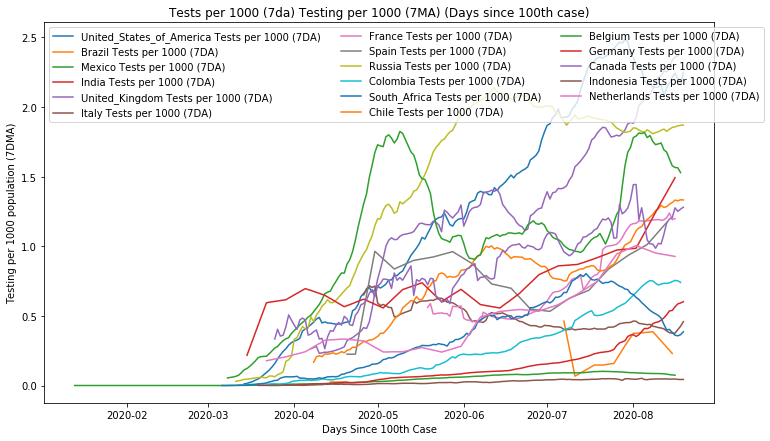

In [401]:
plt.figure(figsize=(12, 7))
i = 'Tests per 1000 (7DA)'
for country in top_count[:]:
    plt.plot(covid19_df[covid19_df["countriesAndTerritories"] == country]["dateRep"],
             covid19_df[covid19_df["countriesAndTerritories"] == country][i], label=f"{country} {i}")
plt.title(str(i).capitalize() + ' Testing per 1000 (7MA) (Days since 100th case)')
plt.xlabel('Days Since 100th Case')
plt.ylabel('Testing per 1000 population (7DMA)')
#plt.yticks(np.arange(min(covid19_df['Tests per 1000 (7DA)']), max(covid19_df['Tests per 1000 (7DA)']), 0.005))
#plt.grid()
plt.legend(ncol=3, loc=2)

In [393]:
covid_df = covid19_df.copy()
covid_df['Tests per 1000 (7DA)'] = covid_df.groupby('countriesAndTerritories')['Tests per 1000 (7DA)'].apply(lambda j: j.interpolate(method='polynomial', limit=None, order=3, limit_direction='both'))

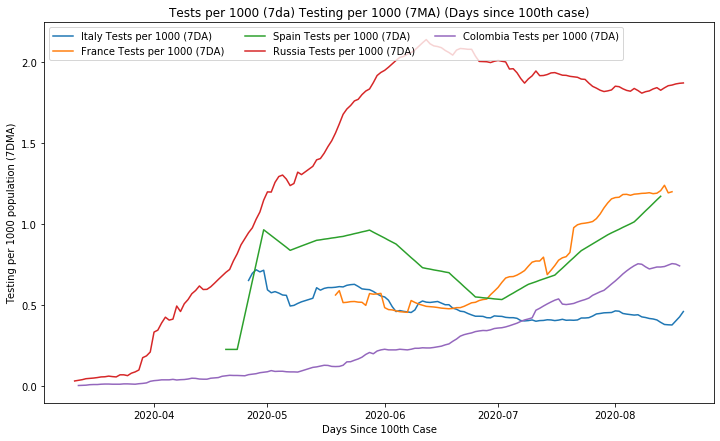

In [399]:
plt.figure(figsize=(12, 7))
i = 'Tests per 1000 (7DA)'
for country in top_count[5:10]:
    plt.plot(covid_df[covid_df["countriesAndTerritories"] == country]["dateRep"],
             covid_df[covid_df["countriesAndTerritories"] == country][i], label=f"{country} {i}")
plt.title(str(i).capitalize() + ' Testing per 1000 (7MA) (Days since 100th case)')
plt.xlabel('Days Since 100th Case')
plt.ylabel('Testing per 1000 population (7DMA)')
#plt.yticks(np.arange(min(covid19_df['Tests per 1000 (7DA)']), max(covid19_df['Tests per 1000 (7DA)']), 0.005))
#plt.grid()
plt.legend(ncol=3, loc=2)

In [306]:
print(list(round(covid19_df.isna().sum()/len(covid_df), 3)))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.325]


In [167]:
# Most of the google trends data is collected weekly. Upscale to daily with a linear interpolation.
for i in google_list:
    covid19_df[i] = covid19_df.groupby('countriesAndTerritories')[i].apply(lambda j: j.interpolate(method='polynomial', limit=None, order=3, limit_direction='both'))
covid19_df['Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'].interpolate(method='linear', limit_direction='both', inplace=True)

In [168]:
# Countries that don't have any transit data.
covid19_df.loc[pd.isnull(covid19_df.transit)]['countriesAndTerritories'].unique()

array(['India', 'Indonesia', 'Russia', 'Chile', 'South_Africa',
       'Colombia'], dtype=object)

In [169]:
# Fill the transit column with the column mean so that it is neutral.
covid19_df['transit'].fillna(covid19_df['transit'].mean(), inplace=True)
# Fill the flag columns NaN's with 0's
covid19_df.flag.fillna(0, inplace=True)
# Remove bad values from 'cases' and 'deaths' (for Spain essentially)
covid19_df = covid19_df.loc[(covid19_df['deaths'] >= 0) & (covid19_df['cases'] >= 0)]

In [170]:
print(list(round(covid19_df.isna().sum()/len(covid19_df), 3)))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [172]:
# Creating an additional target, an 18 day shift in 'deaths', this is based on the average lag between infection and fatality for covid19 patients.
covid19_df['deaths18'] = covid19_df.groupby('countriesAndTerritories')['deaths'].shift(periods=-18)
covid19_df['deaths18'].interpolate(method='linear', limit_direction='both', inplace=True)

In [173]:
"""for m in top_count:
    # Visualising the features.
    fig, ax1 = plt.subplots()
    j = 'Bar'
    country = m
    target = 'deaths'
    ax2 = ax1.twinx()
    ax1.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][j], label=j.capitalize() + ' Google Search Requests', c='darkviolet', linewidth=2)
    ax2.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][target], label=country + ' Daily ' + target.capitalize(), c='mediumblue', linewidth=2)
    ax2.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country]['deaths18'], label=country + ' Daily ' + target.capitalize()+' - 18 days', c='crimson', linewidth=2)

    plt.title(target.capitalize() + ' vs Google Search Requests')
    plt.grid()
    ax1.legend(loc=2)
    ax2.legend(loc=1)
    fig.set_size_inches(18.5, 10.5)

    ax1.set_xlabel('Days Since 100th Case')
    ax1.set_ylabel(j.capitalize() + ' Google Search Requests')
    ax2.set_ylabel('Number of Daily ' + target.capitalize())
    #plt.savefig(i + 'Feature.jpeg', dpi=600)"""

"for m in top_count:\n    # Visualising the features.\n    fig, ax1 = plt.subplots()\n    j = 'Bar'\n    country = m\n    target = 'deaths'\n    ax2 = ax1.twinx()\n    ax1.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][j], label=j.capitalize() + ' Google Search Requests', c='darkviolet', linewidth=2)\n    ax2.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][target], label=country + ' Daily ' + target.capitalize(), c='mediumblue', linewidth=2)\n    ax2.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country]['deaths18'], label=country + ' Daily ' + target.capitalize()+' - 18 days', c='crimson', linewidth=2)\n\n    plt.title(target.capitalize() + ' vs Google Search Requests')\n    plt.grid()\n    ax1.legend(loc=2)\n    ax2.le

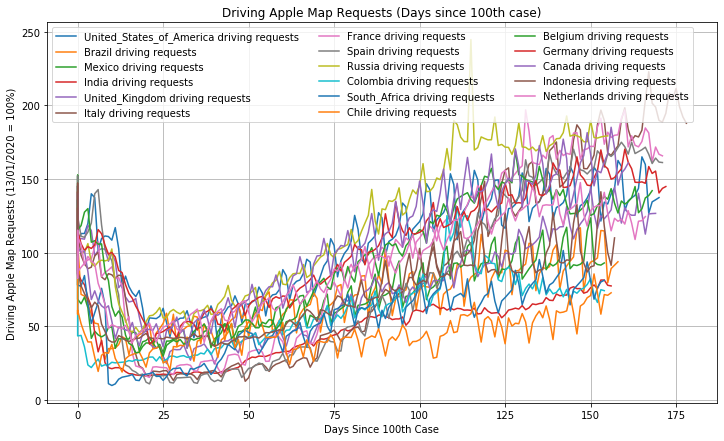

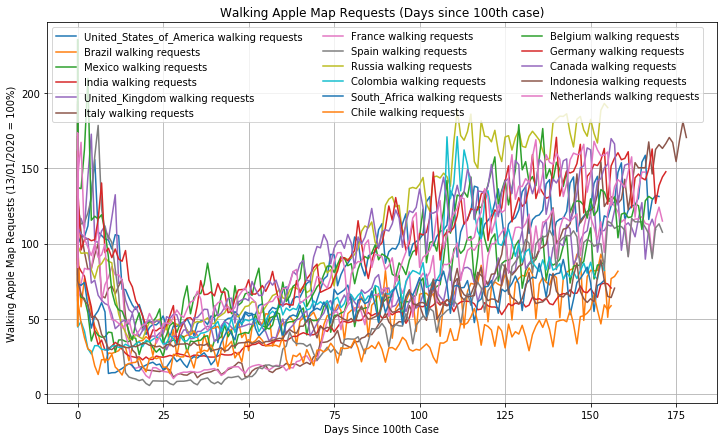

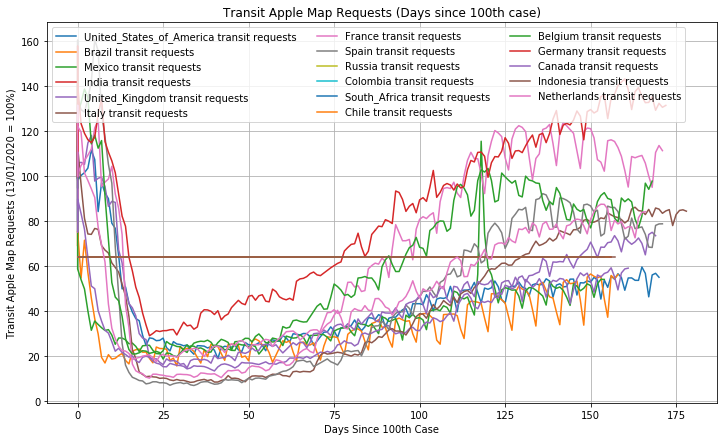

In [174]:
# Visualising the transport use over time by the first 10 countries
for i in transport_list:
    plt.figure(figsize=(12, 7))
    for country in top_count[:]:
        plt.plot(covid19_df[covid19_df["countriesAndTerritories"] == country]["flag"],
                 covid19_df[covid19_df["countriesAndTerritories"] == country][i], label=f"{country} {i} requests")
    plt.title(str(i).capitalize() + ' Apple Map Requests (Days since 100th case)')
    plt.xlabel('Days Since 100th Case')
    plt.ylabel(str(i).capitalize() + ' Apple Map Requests (13/01/2020 = 100%)')
    plt.grid()
    plt.legend(ncol=3, loc=2)

In [175]:
"""for m in top_count:
    # Visualising the features.
    fig, ax1 = plt.subplots()
    j = 'driving'
    i = 'walking'
    k = 'transit'
    country = m
    target = 'cases'
    ax2 = ax1.twinx()
    ax1.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][j], label=j.capitalize() + ' Apple Map Requests', c='darkviolet', linewidth=2)
    ax1.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][i], label=i.capitalize() + ' Apple Map Requests', c='dodgerblue', linewidth=2)
    ax1.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][k], label=k.capitalize() + ' Apple Map Requests', c='deeppink', linewidth=2)
    ax2.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][target], label=country+' Daily Deaths', c='mediumblue', linewidth=2)

    plt.title('Apple Map Requests vs Google Search Requests')
    plt.grid()
    ax1.legend(loc=2)
    ax2.legend(loc=1)
    fig.set_size_inches(12.5, 7.5)

    ax1.set_xlabel('Days Since 100th Case')
    ax1.set_ylabel(j.capitalize() + ' Apple Map Requests')
    ax2.set_ylabel('Number of Daily ' + target.capitalize())
    #plt.savefig(i + 'Feature.jpeg', dpi=600)"""

"for m in top_count:\n    # Visualising the features.\n    fig, ax1 = plt.subplots()\n    j = 'driving'\n    i = 'walking'\n    k = 'transit'\n    country = m\n    target = 'cases'\n    ax2 = ax1.twinx()\n    ax1.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][j], label=j.capitalize() + ' Apple Map Requests', c='darkviolet', linewidth=2)\n    ax1.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][i], label=i.capitalize() + ' Apple Map Requests', c='dodgerblue', linewidth=2)\n    ax1.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][k], label=k.capitalize() + ' Apple Map Requests', c='deeppink', linewidth=2)\n    ax2.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['c

In [178]:
names = list(covid19_df.columns)
remove_list = ['Cumulative_number_for_14_days_of_COVID-19_cases_per_100000', 'deaths18', 'Cum_Cases', 'Cum_Deaths']
for i in remove_list:
    names.remove(i)

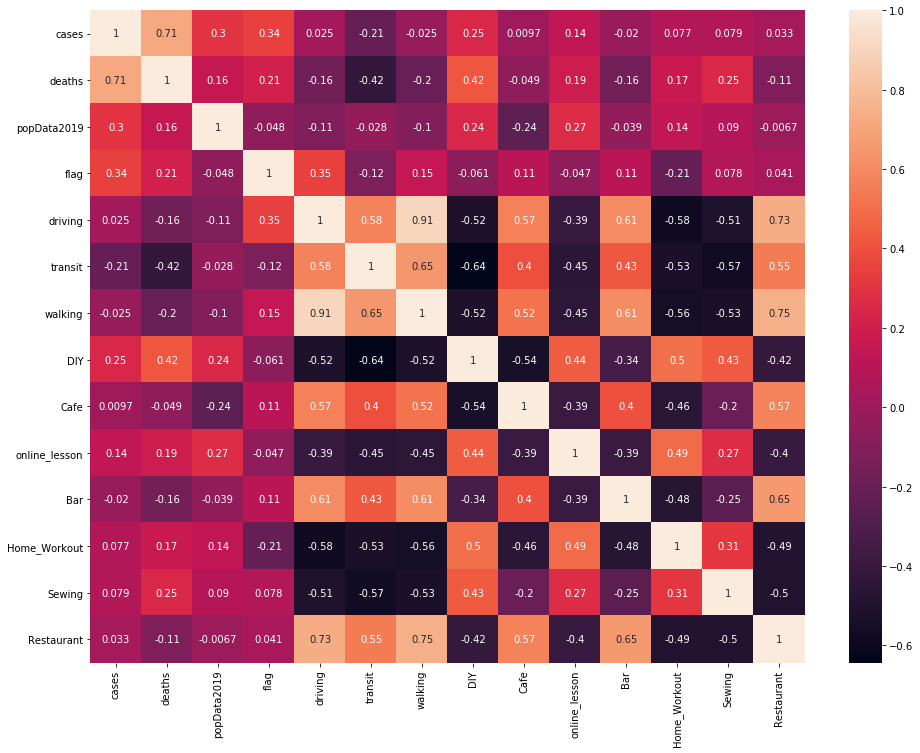

In [179]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))
sns.heatmap(covid19_df[names].corr(), ax=ax, annot=True)

In [ ]:
"""Prepare Data for Export"""

In [196]:
target_country = 'United_Kingdom'

In [215]:
eur_list = ['France', 'Germany', 'Italy', 'Belgium', 'Spain', 'Netherlands']
# using list comprehension to perform task
row_list = [i for i in top_count if i not in eur_list]
row_list.remove(target_country)

In [217]:
covid_df = covid19_df.copy()
for i in eur_list:
    covid_df = covid_df.replace({'countriesAndTerritories': {i: 'Europe'}}, regex=True)
for i in row_list:
    covid_df = covid_df.replace({'countriesAndTerritories': {i: 'Rest_of_World'}}, regex=True)

array(['Rest_of_World', 'Europe', 'United_Kingdom'], dtype=object)

In [219]:
# Use the line below if you want to select only one country to train the model on
#covid_df = covid19_df.loc[covid19_df['countriesAndTerritories']=='United_Kingdom']

<p>Below we export the .csv as a master dataframe. We then do the final processing stages for the train and test datasets</p>

In [220]:
# Check if the folder 'data_export' exists and if not create it.
folder_create = os.path.exists(os.path.join(data_folder, "data_export"))
if folder_create is False:
    os.mkdir(os.path.join(data_folder, "data_export"))
# Export the polished dataframe to re-import after modelling.
covid_df.to_csv(os.path.join(data_folder, "data_export", "covid_df.csv"))

In [234]:
# 'get_dummies' creates a new column for each country that is populated with either a 1 or a 0
df_train = pd.get_dummies(data=covid_df, columns=["countriesAndTerritories"], prefix=[''])
#df_train = covid_df.loc[:, covid_df.columns != 'countriesAndTerritories'].copy()
# df_y is target to predict, in this case 'deaths'
df_y = df_train[['deaths', 'deaths18', 'dateRep', 'cases']]
# df_train contains the columns we will use to predict 'deaths'
df_train.drop(columns=['deaths18', 'popData2019', 'cases', 'deaths', 'Cum_Cases', 'Cum_Deaths', 'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000', 'continentExp'], inplace=True)

In [235]:
df_train.head(3)

,dateRep,flag,driving,transit,walking,DIY,Cafe,online_lesson,Bar,Home_Workout,Sewing,Restaurant,_Europe,_Rest_of_World,_United_Kingdom
0,2020-01-13,0.0,100.0,63.982356,100.0,51.0,75.0,27.0,59.0,12.0,59.0,70.0,0,1,0
1,2020-01-13,0.0,100.0,100.000000,100.0,66.0,78.0,55.0,70.0,7.0,50.0,24.0,1,0,0
2,2020-01-13,0.0,100.0,100.000000,100.0,42.0,60.0,17.0,71.0,11.0,37.0,52.0,0,0,1


In [236]:
data_path = os.path.join(data_folder, "data")
# Check if the 'data' folder exists, if not create it
folder_create = os.path.exists(data_path)
if folder_create is False:
    os.mkdir(data_path)
    # Create 'train' and 'test' folders if the data folder does not exist.
    os.mkdir(os.path.join(data_path, "train"))
    os.mkdir(os.path.join(data_path, "test"))

In [237]:
# Instead of randomly splitting the data we will select a date to test 'blind' from
date_slice = '2020-08-01'

In [238]:
# Data split according to the date. 'train'=before date, 'test'=after.
X_train = df_train.loc[df_train['dateRep'] < date_slice]
X_test = df_train.loc[df_train['dateRep'] >= date_slice]
y_train = df_y.loc[df_y['dateRep'] < date_slice]
y_test = df_y.loc[df_y['dateRep'] >= date_slice]

In [239]:
# Export these four dataframes for later.
X_train.to_csv(os.path.join(data_path, "train", "train_x.csv"))
y_train.to_csv(os.path.join(data_path, "train", "train_y.csv"))
X_test.to_csv(os.path.join(data_path, "test", "test_x.csv"))
y_test.to_csv(os.path.join(data_path, "test", "test_y.csv"))